In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Método de Elemento Finito.

# Problema 2.b, página 373.
$$ y'' = 3y - 2y' $$
con condiciones de frontera $ y (0) = e^3$, $y(1) = 1$.

Solución exacta, $y = e^{3-3t}$.

In [ ]:
def y(t):
  return np.exp(3 - 3*t)

Metodología

In [ ]:
# Condiciones del problema
a, b = 0, 1
ya, yb = np.exp(3), 1
N = 10 # Número de nodos

# Grid
t = np.linspace(a, b, N) # Contabilizar los extemos como extras
h = t[1] - t[0]

alpha = h/2 - 1 - 1/h # Coef: i, i-1
beta  = 2*h + 2/h     # Coef: i, i
gamma = h/2 + 1 - 1/h # Coef: i, i+1

print(f'Tamaño de paso {h:.3f}')

Tamaño de paso 0.111


In [ ]:
# Ecuaciones
n =  N-2

Ds = gamma*np.ones(n-1)
Dp = beta*np.ones(n)
Di = alpha*np.ones(n-1)

# Matriz de la forma
A = np.diag(Ds, -1) + np.diag(Dp) + np.diag(Di, 1)

# Vector
v = np.zeros(n)
v[0], v[-1] = -ya*gamma, -yb*alpha

In [ ]:
c = np.linalg.solve(A, v)
c = np.concatenate(([ya], c, [yb]))

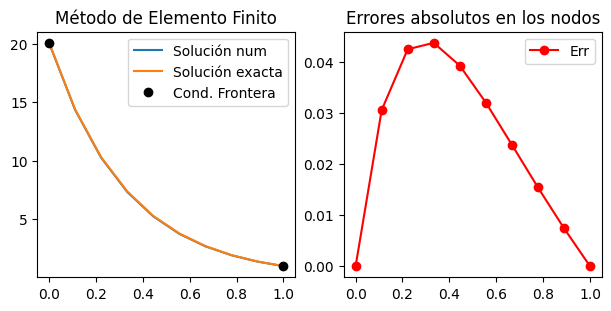

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (6, 3), layout='constrained')

ax[0].plot(t, c, label = 'Solución num')
ax[0].plot(t, y(t), label = 'Solución exacta')
ax[0].plot([a,b], [ya,yb], 'ok', label = 'Cond. Frontera')

ax[0].set_title('Método de Elemento Finito')
ax[0].legend()

ax[1].plot(t, np.abs(c - y(t)), 'o-r', label = 'Err')

ax[1].set_title('Errores absolutos en los nodos')
ax[1].legend()

plt.show()

# Extención de la solución fuera de los nodos.

En esta sección se busca determinar la función modelo y evaluarla fuera de los puntos para los cuales se cálcularon los coeficientes.

In [ ]:
def phi(t, I):
  """
  t :  es el valor a evualuar
  I : tupla con los valores (t_i-1, t_i, t_i+1)
  """
  if I[0] < t <= I[1]:
    return (t-I[0])/(I[1] - I[0])
  elif I[1] <= t < I[2]:
    return (I[2] - t)/(I[2] - I[1])
  else:
    return 0

def modelo_ef(t, c, phi, grid):
  """
  t : valor a evaluar
  c : coeficientes de elemento finito
  phi : función base
  grid : grid
  """
  if t < grid[0] or grid[-1] < t:
    return 0

  sum = c[0]*phi(t, (np.nan, grid[0], grid[1])) + c[-1]*phi(t, (grid[-2], grid[-1], np.nan))

  for i in range(1, len(grid) -1):
    I = (grid[i-1], grid[i], grid[i+1])
    sum += c[i]*phi(t, I)

  return sum

In [ ]:
grid = np.linspace(a, b, 30)

sol = []
for T in grid:
  sol.append(modelo_ef(T, c, phi, t))
sol = np.array(sol)

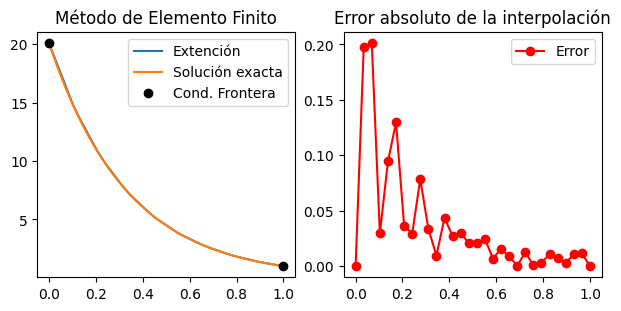

In [ ]:
# Gráfica
fig, ax = plt.subplots(ncols = 2, figsize = (6, 3), layout='constrained')

ax[0].plot(grid, sol, label = 'Extención')
ax[0].plot(grid, y(grid), label = 'Solución exacta')
ax[0].plot([a,b], [ya,yb], 'ok', label = 'Cond. Frontera')

ax[0].set_title('Método de Elemento Finito')
ax[0].legend()

ax[1].plot(grid, np.abs(sol - y(grid)), 'o-r' , label = 'Error')
# ax[1].plot(t, h*np.ones(len(t)), '--', label = 'h')
ax[1].set_title('Error absoluto de la interpolación')

ax[1].legend()

plt.show()

# Orden del método

Para estimar el orden del método se busca coparar el error sobre la norma $L_\infty$ en diferentes *grids* cada uno de el doble de cantidad que el anterior.

Para ello usamos la aproximación del orden

$$ ord = \frac{\ln(E_2 E_1) }{\ln(N_2/N_1) } $$

En este caso, $E_i$ es el error del *grid* $i$ y $N_i$ es la cantidad de puntos del *grid* $i$.

In [ ]:
def elementoFinito(N):
  # Grid
  t = np.linspace(a, b, N) # Contabilizar los extemos como extras
  alpha = h/2 - 1 - 1/h # Coef: i, i-1
  beta  = 2*h + 2/h     # Coef: i, i
  gamma = h/2 + 1 - 1/h # Coef: i, i+1
  # Ecuaciones
  n =  N-2
  # Diagonales
  Ds = gamma*np.ones(n-1)
  Dp = beta*np.ones(n)
  Di = alpha*np.ones(n-1)
  # Matriz de la forma
  A = np.diag(Ds, -1) + np.diag(Dp) + np.diag(Di, 1)
  # Vector
  v = np.zeros(n)
  v[0], v[-1] = -ya*gamma, -yb*alpha
  coef = np.linalg.solve(A, v)
  coef = np.concatenate(([ya], coef, [yb]))
  return t, coef

In [ ]:
def err(N):
  t, coef = elementoFinito(N)
  return t[1] - t[0], np.max(np.abs(coef - y(t)))

In [ ]:
Pts = [10, 20, 40, 80, 160]
errores = []
pasos = []
for i in Pts:
  h, er = err(i)
  pasos.append(h)
  errores.append(er)

In [ ]:
def aprox_ord(errmax):
  ord = []
  for n1, n2, h1, h2 in zip(pasos[:-1], pasos[1:], errmax[:-1], errmax[1:]):
    ord.append(np.log2(h1*h2) / np.log2(n2/n1))
  return ord

aprox_ord(errores)

[np.float64(1.9589528520133819),
 np.float64(-4.565087787364978),
 np.float64(-4.556628176886217),
 np.float64(-4.556149196782921)]

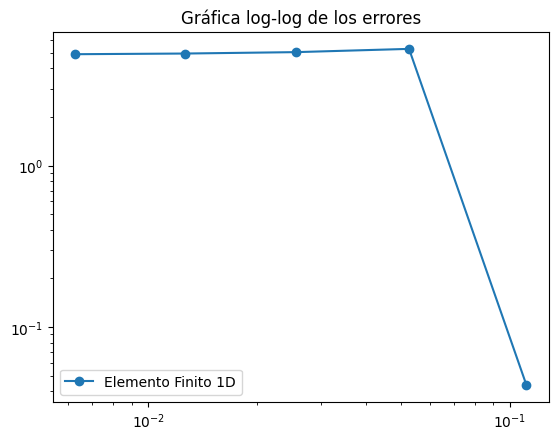

In [ ]:
# Gráfica log-log
plt.loglog(pasos, errores, '-o', label = 'Elemento Finito 1D')

plt.title('Gráfica log-log de los errores')
plt.legend()
plt.show()